In [1]:
import os
import sys
import time
import errno
import time
import timeit
import pickle
import gc
import multiprocessing as mp
from IPython.display import HTML

import matplotlib.pyplot as plt
import seaborn as sns

import sbi 
import sbi.inference
from sbi.inference.base import infer
from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, DirectPosterior, MCMCPosterior, VIPosterior
from sbi.analysis import ActiveSubspace, pairplot
import sbi.utils as utils


import numpy as np
import pandas as pd
import xarray as xr
import scipy as scp
from scipy import signal, interpolate, stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
import arviz as az
from tqdm.notebook import tqdm, trange


import jax 
import jax.numpy as jnp
from jax.lib import xla_bridge
from jax import random
from jax import grad, vmap, lax, random
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cuda")
print(f"number of cores:", jax.local_device_count())
print(f"using: ", xla_bridge.get_backend().platform)
rng_key = random.PRNGKey(0)

from functools import partial
from jax.experimental.ode import odeint
import torch
from lib import TruncatedNormal
import numba
from numba import jit
import numpyro as npyr
from numpyro import sample, plate
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

number of cores: 1
using:  gpu


## Feature functions

## 2. Simulations

In [ ]:
parent_preprocess_dir = ''
fig_save_loc = ''

cwd = os.getcwd()

In [3]:
cpu_device = jax.devices('cpu')[0]
selected_device = cpu_device

jax.config.update('jax_default_device', selected_device)

In [4]:
tend = 100.0
ds_sim = 5
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]
ns = 9
nt

1001

In [5]:
x_init=np.zeros((ns))

In [6]:
alpha=-0.56
constants=np.array([alpha])

In [7]:
g_1=0.0045
g_2=1.5
g_3=0.1
g_4=0.15

In [9]:
theta_true = np.array([g_1, g_2, g_3, g_4])
num_params = theta_true.shape[0]
num_params

4

In [10]:
def DCM_default_params():

    delta=8.41
    tau_i=7.77
    h_i=27.87
    tau_e=5.77
    h_e=1.63
    u=3.94
    
    return delta, tau_i, h_i, tau_e, h_e, u

In [11]:
@jax.jit
def Sigmodal(x1, x2, delta, alpha):
    S=(1./(1.+jnp.exp(alpha*(x1-(delta*x2)))))-0.5
    return S

In [12]:
@jax.jit
def DCM_NMM_ERP_vector_field(state, t, constants, params):
    
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = state
    g_1, g_2, g_3, g_4 = params
    delta, tau_i, h_i, tau_e, h_e, u = DCM_default_params()
    
    alpha = constants[0]

    dx0 = x3
    dx1 = x4
    dx2 = x5
    dx3 = (1./tau_e) * (h_e * (g_1 * (Sigmodal(x8, x4 - x5, delta, alpha)) + u) - (x0 / tau_e) - 2 * x3)
    dx4 = (1./tau_e) * (h_e * (g_2 * (Sigmodal(x0, x3, delta, alpha))) - (x1 / tau_e) - 2 * x4)
    dx5 = (1./tau_i) * (h_i * (g_4 * (Sigmodal(x6, x7, delta, alpha))) - (x2 / tau_i) - 2 * x5)
    dx6 = x7
    dx7 = (1. / tau_e) * (h_e * (g_3 * (Sigmodal(x8, x4 - x5, delta, alpha))) - (x6 / tau_e) - 2 * x7)
    dx8 = x4 - x5

    return jnp.array([dx0, dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8])


In [13]:
def odeint_euler(f, y0, t, *args):
    def step(state, t):
            y_prev, t_prev = state
            dt = t - t_prev
            y = y_prev + dt * f(y_prev, t_prev, *args)
            return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[0:])

    return ys

In [14]:
def odeint_rk4(f, y0, t, *args):
    def step(state, t):
            y_prev, t_prev = state
            h = t - t_prev
            k1 = h * f(y_prev, t_prev, *args)
            k2 = h * f(y_prev + k1/2., t_prev + h/2., *args)
            k3 = h * f(y_prev + k2/2., t_prev + h/2., *args)
            k4 = h * f(y_prev + k3, t + h, *args)
            y = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
            return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[0:])
    return ys

In [15]:
def get_batch_params(params, batch_size, batch_ind):
    
    batch_pars = deepcopy(params)
    
    batch_pars = params[:, batch_size*batch_ind : batch_size*(batch_ind+1)]

    return batch_pars

In [16]:
start_time = time.time()

xs_euler = odeint_euler(DCM_NMM_ERP_vector_field,  x_init, ts, constants, theta_true)

print("similations took using Euler odeint (sec):" , (time.time() - start_time))

similations took using Euler odeint (sec): 0.08372950553894043


In [17]:
start_time = time.time()

xs_rk4 = odeint_rk4(DCM_NMM_ERP_vector_field, x_init, ts, constants, theta_true)

print("similations took using RK4 odeint (sec):" , (time.time() - start_time))

similations took using RK4 odeint (sec): 0.10706853866577148


But don't worry! we put JAX's JIT on Odeint!

In [18]:
@jax.jit
def DCM_NMM_ERP_ODE_JAXOdeint(params, constants, x_init, ts):

    xs_rk4 = odeint_euler(DCM_NMM_ERP_vector_field,  x_init, ts, constants, params)
    x_py=xs_rk4[:,8]
    
    return x_py

In [19]:
start_time = time.time()

xpy_jax=DCM_NMM_ERP_ODE_JAXOdeint(theta_true, constants, x_init, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.05341768264770508


In [20]:
start_time = time.time()

xpy_jax=DCM_NMM_ERP_ODE_JAXOdeint(theta_true, constants, x_init, ts)

print("similations took (sec):" , (time.time() - start_time))

similations took (sec): 0.00036907196044921875


In [21]:
ts.shape, xpy_jax.shape

((1001,), (1001,))

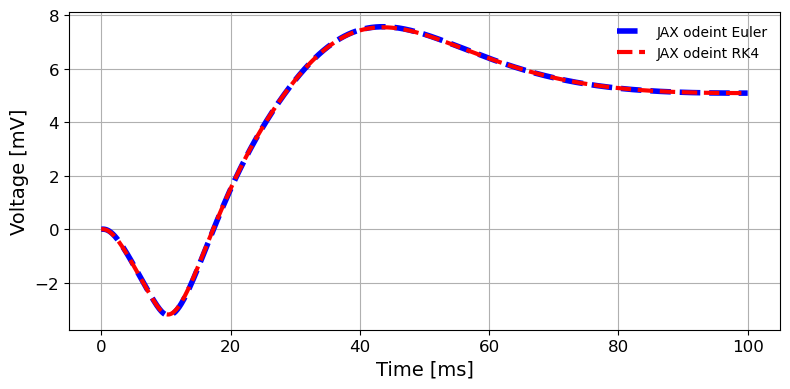

In [22]:
plt.figure(figsize=(8,4))
plt.plot(ts, xs_euler[:,8],'--', color='b', lw=4, label='JAX odeint Euler');
plt.plot(ts, xs_rk4[:,8],'--', color='r', lw=3, label='JAX odeint RK4');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout();
plt.show()

### Prior over model parameters

Here we provide a plausible ranges for the parameters that we aim to infer, by placing a uniform prior on them.

In [23]:
prm_names = ['g_1', 'g_2', 'g_3', 'g_4']

In [24]:
prior_min = [0.01, 0.02, 0.01, 0.01]
prior_max = [0.1, 1.5, 0.1, 0.3]

# prior_min = [0.02, 0.1, 0.02, 0.02]
# prior_max = [0.5, 1.5, 0.5, 0.5]

prior_dist = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
prior, _, _ = utils.user_input_checks.process_prior(prior_dist)

In [25]:
num_prior_samples = 1000
prior_theta_samples = prior.sample((num_prior_samples,))
prior_theta_samples.shape

torch.Size([1000, 4])

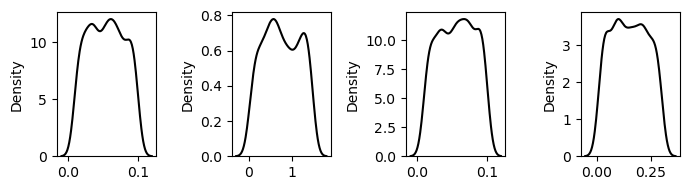

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(7, 2))
for iprm, prm in enumerate(prm_names):
    sns.kdeplot(prior_theta_samples[:,iprm], color='k', ax=ax[iprm]);
fig.tight_layout()

In [27]:
prior_predictions = np.zeros((num_prior_samples, nt))

for s_ind in trange(num_prior_samples):
    theta_sample = prior_theta_samples[s_ind, :]
    prior_predictions[s_ind, :] = DCM_NMM_ERP_ODE_JAXOdeint(theta_sample.numpy(), constants, x_init, ts)

  0%|          | 0/1000 [00:00<?, ?it/s]

prior predictive checks

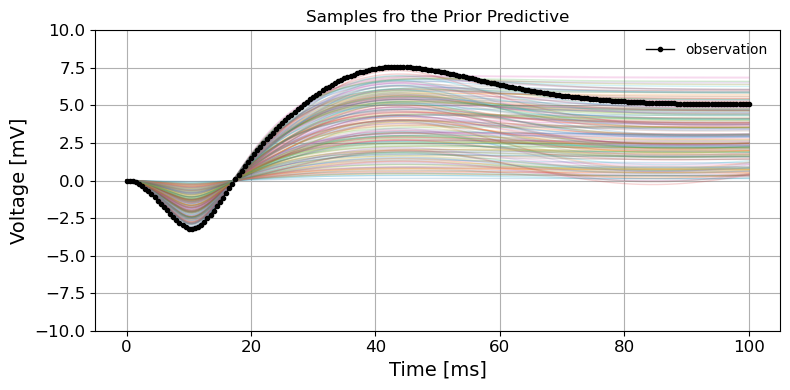

In [28]:
plt.figure(figsize=(8, 4))

for i in range(num_prior_samples):
    if i % 5 == 0:
        plt.plot(ts[::ds_sim], prior_predictions[i,::ds_sim], lw=1, alpha=0.2)
plt.plot(ts[::ds_sim], xpy_jax[::ds_sim] ,'.-', color='k', lw=1, label='observation');
plt.title('Samples fro the Prior Predictive')
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.ylim([-10, 10])
plt.tight_layout();
plt.show()

## Batch simulation

In [29]:
num_sim = 10000
# nWorkers = 8
# batchSize = 2500
# numBatch = int(num_sim/batchSize)

In [ ]:
input_dir = './DCM_ERP_SBI/input/'
output_dir = './DCM_ERP_SBI/output/'

sim_name = 'JR_EC_' + str(num_sim)
sim_path = input_dir+'/'+sim_name

try:
    os.mkdir(sim_path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

theta = prior.sample((num_sim,))

In [31]:
sim_path = input_dir + sim_name
posterior_path = output_dir + sim_name

overwrite = False

if not os.path.exists(sim_path):
    os.mkdir(sim_path)

if not os.path.exists(posterior_path):
    os.mkdir(posterior_path)

if overwrite:
    torch.save(theta, f=sim_path + '/theta.pt')
    torch.save(prior_dist, f=sim_path + '/prior.pt')

theta = torch.load(sim_path+'/theta.pt')

In [32]:
num_batches = 1
batch_size = int(num_sim/num_batches)

In [ ]:
for batch_ind in trange(num_batches):
 
    theta_batch = theta[batch_size*batch_ind : batch_size*(batch_ind+1), :]
    sim_batch = np.zeros((batch_size, nt))
    
    for s_ind in trange(batch_size):
    
        sim_batch[s_ind, :] = DCM_NMM_ERP_ODE_JAXOdeint(theta_batch[s_ind, :].numpy(), constants, x_init, ts)
    
    np.savez(sim_path + '/simulations_' + str(batch_ind) + '.npz', x=sim_batch, theta=theta_batch)

    del(sim_batch); gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [1020]:
for batch_ind in range(num_batches):

    data = np.load(sim_path + '/simulations_' + str(batch_ind) + '.npz')
    
    if batch_ind == 0:
        sim_array = data['x']
    else:
        sim_array = np.concatenate((sim_array, data['x']), axis = -1)

    del(data);gc.collect();

In [ ]:
sim_array.to_netcdf(parent_preprocess_dir + '/erp_sim_array.nc')

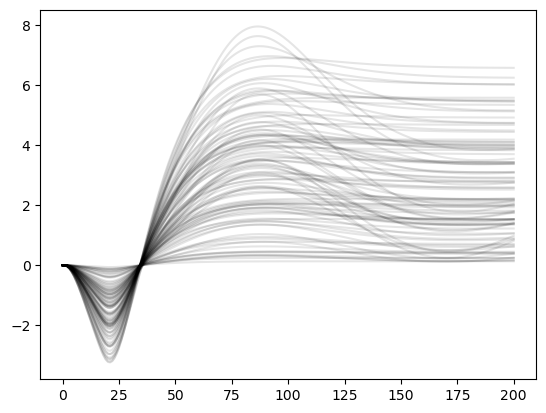

In [1021]:
sim_dims = ('simulation', 'time')
sim_array = xr.DataArray(sim_array, dims=sim_dims)
# plt.plot(sim_array[:,:,-1]);
sim_array.to_netcdf(sbi_path + '/simulations.nc')
sim_step = 100
plt.plot(sim_array[::sim_step, ::5].T, 'k', alpha=0.1);

# 3. Calculate features

In [33]:
sim_array = xr.load_dataarray(parent_preprocess_dir + '/erp_sim_array.nc')

In [37]:
head_window = np.arange(100, 400)
tail_window = np.arange(400,700)

sim_maxs = sim_array.max('time')
sim_tail_range = sim_maxs - sim_array.isel(time=-1)
sim_tail_range /= sim_tail_range.max()
sim_tail_grads = np.gradient(sim_array.sel(time=tail_window), axis=1)
sim_grad_maxs = sim_tail_grads.max(1)

In [38]:
feature_array = xr.concat((sim_maxs, sim_tail_range), dim='summary')
feature_array.coords['summary'] = ['max', 'tail_range']

In [39]:
sel_feature_names = ['max', 'tail_range']
sel_feature_names = ['max']

x_feature_array = feature_array.sel(summary=sel_feature_names)

num_features = len(x_feature_array.summary)

In [40]:
normalize = False

x_features = torch.tensor(x_feature_array.to_numpy(), dtype=torch.float32).T

if normalize:
    x_features = preprocessing.MaxAbsScaler().fit_transform(x_features)
    x_features = torch.as_tensor(x_features.astype(np.float32))

x_features.shape, theta.shape

(torch.Size([10000, 1]), torch.Size([10000, 4]))

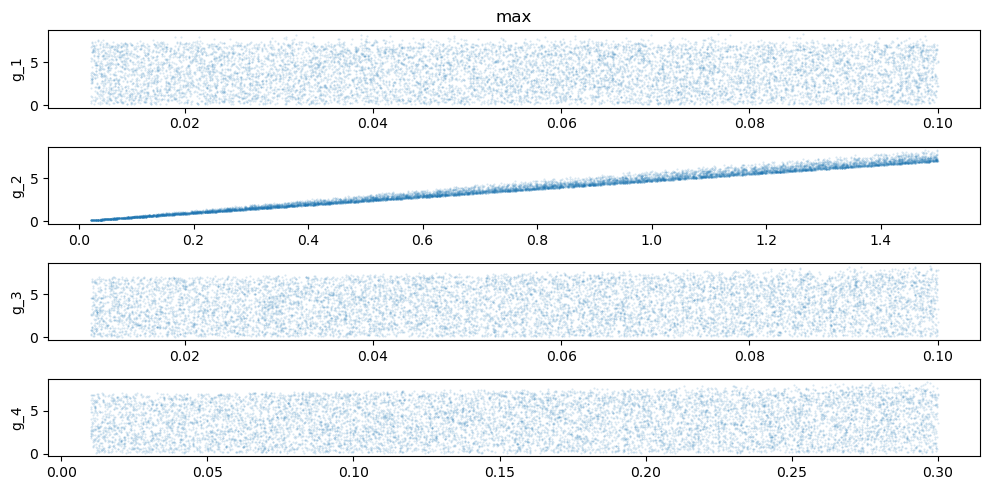

In [41]:
fig,axes = plt.subplots(4, num_features, figsize=(10,5))

if num_features == 1:
    axes = axes.reshape(-1,1)

for p_ind, prm in enumerate(prm_names):

    for f_ind, f_name in enumerate(sel_feature_names):    
        axes[p_ind, f_ind].scatter(theta[:, p_ind], x_features[:, f_ind], alpha=0.2, s=0.2)

        if p_ind == 0:
            axes[p_ind, f_ind].set_title(f_name)
        if f_ind == 0:
            axes[p_ind, f_ind].set_ylabel(prm)

fig.tight_layout()

In [42]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = torch.as_tensor(theta)

In [43]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 4])
data feature shape: torch.Size([10000, 1])


# 4. Inference

In [ ]:
estimator_type = 'nsf'

saveString = 'features_'+ '-'.join(sel_feature_names) + '_' + estimator_type
print(saveString)

features_max_nsf


In [ ]:
start_time = time.time()

inference = SNPE(prior, density_estimator=estimator_type, device='cpu')
posterior_estimator = inference.append_simulations(theta, x_features).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

with open(posterior_path + '/' + saveString + '.pkl', 'wb') as f:
    pickle.dump(posterior_estimator,f)

 Neural network successfully converged after 90 epochs.------------------------------------------------------------
---training took:  290.99993538856506 seconds ---


In [45]:
posterior_file = open(posterior_path + '/' + saveString + '.pkl', "rb")
posterior_estimator = pickle.load(posterior_file)
posterior_file.close()

In [90]:
import matplotlib.ticker as plticker

def modify_axis_spines(ax, which=None, base=1.0, xticks=[], yticks=[], yaxis_left=True, xaxis_bot=True):

    tick_locator = plticker.MultipleLocator(base=base)

    if yaxis_left: 
        ax.spines.right.set(visible=False)
        yspine = ax.spines.left
    else:
        ax.spines.left.set(visible=False)
        yspine = ax.spines.right
        
    if xaxis_bot:
        ax.spines.top.set(visible=False)
        xspine = ax.spines.bottom
    else:
        ax.spines.bottom.set(visible=False)
        xspine = ax.spines.top
                           
    if 'x' in which:
        if len(xticks) == 0:
            xticks = ax.get_xticks() 
            ax.xaxis.set_major_locator(tick_locator)
        ax.set_xticks(xticks)
        xspine.set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])
        
    else:
        ax.spines.bottom.set(visible=False)
    
    if 'y' in which:
        if len(yticks) == 0:
            yticks = ax.get_yticks()
        ax.set_yticks(yticks)
        yspine.set_bounds(ax.get_yticks()[0], ax.get_yticks()[-1])
        if len(yticks) == 0:
            ax.yaxis.set_major_locator(tick_locator)
    else:
        ax.spines.left.set(visible=False)

def fmt_plot_text(text):
    return f'{text:.2f}'

def get_source_time_label(time_value):
    return 'Time from ball movement: {} ms'.format(np.round(time_value*1000))

# Synthetic validation

In [79]:
theta_true_ind = np.random.choice(np.arange(theta.shape[0]))
theta_true_sample = theta[theta_true_ind, :]

theta_true_feat = x_features[theta_true_ind,:]

In [80]:
theta_true_ind, theta_true_sample

(282, tensor([0.0540, 1.2877, 0.0650, 0.2615]))

In [83]:
num_samples=2000
posterior = DirectPosterior(posterior_estimator, prior)

theta_pred = posterior.sample((num_samples,), theta_true_feat).numpy().squeeze()    
theta_pred_max = np.mean(theta_pred,0)

theta_true_erp = DCM_NMM_ERP_ODE_JAXOdeint(theta_true_sample.numpy(), constants, x_init, ts)
theta_pred_erp = DCM_NMM_ERP_ODE_JAXOdeint(theta_pred_max, constants, x_init, ts)

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

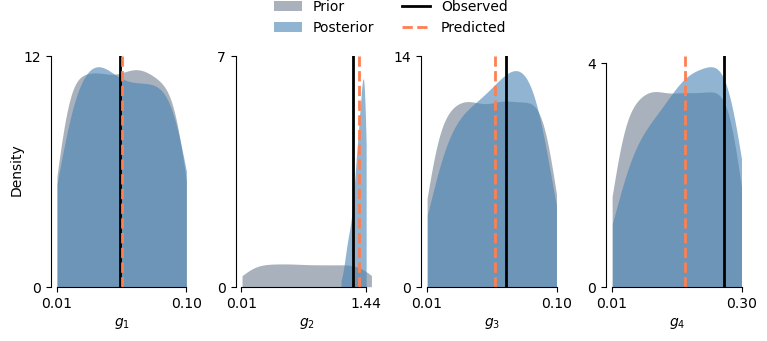

In [ ]:
fig,axes = plt.subplots(1,4, figsize=(9,3))

truth_color = 'k'
pred_color = 'coral'
bw_adjust=2

for ax_ind, ax in enumerate(axes.ravel()):

    sns.kdeplot(theta[:, ax_ind].numpy().ravel(), ax=ax, shade=True, linewidth=0, color='slategray', alpha=0.6, label='Prior', cut=0, bw_adjust=bw_adjust)
    sns.kdeplot(theta_pred[:, ax_ind], ax=ax, shade=True, linewidth=0, color='steelblue', alpha=0.6, label='Posterior', cut=0, bw_adjust=bw_adjust)
    ax.axvline(theta_true_sample.numpy()[ax_ind], ymin=0, c=truth_color, ls='-', label='Observed', lw=2)
    ax.axvline(theta_pred_max[ax_ind], ymin=0, c=pred_color, ls='--', label='Predicted', lw=2)
    ax.set_xlabel('$g_{}$'.format(ax_ind+1))
    ax.set_ylabel('')
    
    if ax_ind == 0:
        handles, labels = ax.get_legend_handles_labels()

    modify_axis_spines(ax, which=['x','y'], xticks=[0.01, theta_pred[:, ax_ind].max().round(2)], yticks=[0, ax.get_ylim()[1].round()])

fig.supylabel('Density',x=0.08, fontsize=10)
fig.legend(handles, labels, frameon=False, loc=(0.35, 0.88), ncols=2)
fig.subplots_adjust(wspace=0.3)
fig.savefig(fig_save_loc + '/ERP/SBI_validation_posteriors.svg', transparent=True)

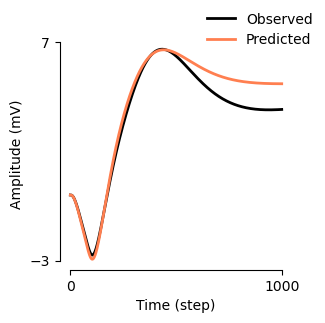

In [201]:
fig, ax = plt.subplots(figsize=(3,3))

markersize=10
lw=2

ax.plot(theta_true_erp, lw=lw, label='Observed', c=truth_color)
ax.plot(theta_pred_erp, lw=lw, label='Predicted', c=pred_color)

modify_axis_spines(ax, which=['x','y'], xticks=[0, 1000], yticks=[-3, 7])
    
ax.set_xlabel('Time (step)')
ax.set_ylabel('Amplitude (mV)')

fig.legend(frameon=False)
fig.savefig(fig_save_loc + '/ERP/SBI_validation_erps.svg', transparent=True)

torch.Size([10000, 4])

# Preparing Empirical Data

In [ ]:
def plot_all_ERPs(fig, ax, data, color='k', lw=1, alpha=0.5):

    time_vec = np.linspace(-max_lag*1000, max_lead*1000, data.shape[0])    

    ax.plot(data.reshape(time_vec.shape[0], -1), c=color, lw=lw, alpha=alpha)

    ymin, ymax = data.min().round(1), data.max().round(1)
            
    ax.set_ylabel(r'Amplitude (mV)')
    ax.set_xlabel('Time (ms)')
    ax.set_aspect('auto', adjustable='box')

In [1034]:
task_ERPs = xr.load_dataarray(parent_preprocess_dir + 'task_ERPs_AllRegions.nc')

x_obs = task_ERPs.isel(electrode=0, condition=0).to_numpy()

num_conditions = len(task_ERPs.condition)
num_electrodes = len(task_ERPs.electrode)
num_timepoints = task_ERPs.time.shape[0]

max_lag = task_ERPs.attrs['MaxLag']
max_lead = task_ERPs.attrs['MaxLead']

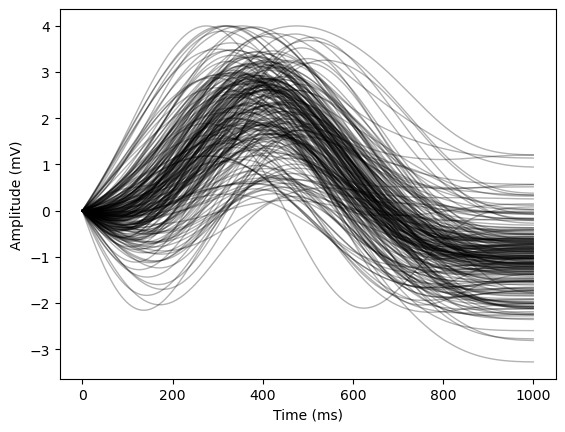

In [1035]:
fig, ax = plt.subplots()
plot_all_ERPs(fig, ax, task_ERPs.to_numpy(), alpha=0.3,)

In [1036]:
emp_maxs = task_ERPs.max('time')
emp_tail_range = emp_maxs - task_ERPs.isel(time=-1)
emp_tail_range /= emp_tail_range.max()
emp_tail_range -= 0.05

In [1037]:
emp_feature_array = xr.concat((emp_maxs, emp_tail_range), dim='summary')
emp_feature_array.coords['summary'] = ['max', 'tail_range']

In [1038]:
emp_features = emp_feature_array.sel(summary=sel_feature_names).to_numpy()

if normalize:
    
    emp_features_ravel = preprocessing.RobustScaler().fit_transform(emp_features.reshape(-1,1))
    # emp_features_ravel = preprocessing.MinMaxScaler().fit_transform(emp_features.reshape(-1,1))
    emp_features = emp_features_ravel.reshape(emp_features.shape)

In [1039]:
print('max')
print(x_features.numpy().max(0), emp_features.max((-2,-1)))
print('min')
print(x_features.numpy().min(0), emp_features.min((-2,-1)))

max
[8.277189] [4.]
min
[0.09744458] [0.22293934]


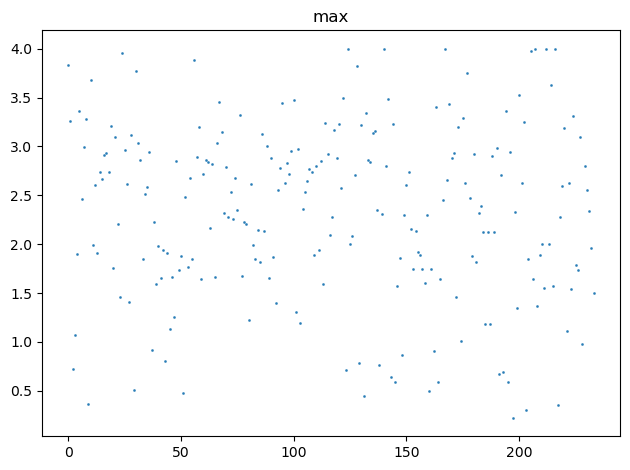

In [1040]:
fig,axes = plt.subplots(1, num_features)

if num_features == 1:
    axes = [axes]

for f_ind, f_name in enumerate(sel_feature_names):    
    p_features = emp_features.reshape(num_features,-1)[f_ind,:]
    axes[f_ind].scatter(np.arange(p_features.shape[0]), p_features, alpha=0.8, s=1)
    axes[f_ind].set_title(f_name)
    # axes[f_ind].set_yticks(np.arange(0,1.1,0.2))
fig.tight_layout()

In [1041]:
num_samples = 2000
posterior = DirectPosterior(posterior_estimator, prior,)

theta_dims = ('theta', 'sample', 'electrode', 'condition')

posterior_coords = dict(electrode=task_ERPs.electrode, condition=task_ERPs.condition, theta=prm_names)

emp_posterior = xr.DataArray(np.zeros((num_params, num_samples, num_electrodes, num_conditions)),
                          dims=theta_dims, coords=posterior_coords)
emp_posterior.coords['theta'] = ['g_1', 'g_2', 'g_3', 'g_4']

posterior_maxs = xr.DataArray(np.zeros((num_params, num_electrodes, num_conditions)),
                          dims=('theta', 'electrode', 'condition'), coords=posterior_coords)

In [ ]:
for e_ind in trange(num_electrodes, desc='Electrode: ', leave=False):
    for c_ind in range(num_conditions):
        
        theta_posterior = posterior.sample((num_samples,), emp_features[:, e_ind, c_ind], show_progress_bars=False).numpy()
        emp_posterior[:, :, e_ind, c_ind] = theta_posterior.T
        posterior_maxs[:, e_ind, c_ind] = np.median(theta_posterior,0)

Electrode:   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
emp_posterior.to_netcdf(parent_preprocess_dir + 'erp_sbi_thetas.nc')
posterior_maxs.to_netcdf(parent_preprocess_dir + 'erp_sbi_thetas_maxs.nc')

## All Sessions

In [ ]:
emp_posterior = xr.load_dataarray(parent_preprocess_dir + 'erp_sbi_thetas.nc')

In [1045]:
df = emp_posterior.stack(aggSample=('theta', 'sample',  'electrode', 'condition'))
df = df.to_dataframe(name = 'value')
dfInds = df.index
df.index = np.arange(len(dfInds))

In [1046]:
palette = {'Presence': 'dodgerblue', 'Absence': 'crimson'}

bw = 0.3
width_viol = 0.5
orient = 'v'
alpha = .99
dodge = True
pointplot = False
move = 0.2
point_size = 0
cut = 0.5
scale = 'area'
width_box = 0.5
line_width = 0.1
saturation = 1

In [1047]:
# (Replace with your Wasserstein distance calculation function)
def wasserstein_distance(sample1, sample2, n_permutations=100):

    combined_data = np.concatenate([sample1, sample2])
    observed_distance = stats.wasserstein_distance(sample1, sample2)
    
    # Number of permutations
    p_value = 0
    for _ in range(n_permutations):
      # Shuffle data points within combined sample
      shuffled_data = np.random.permutation(combined_data)
      shuffled_sample1 = shuffled_data[:len(sample1)]
      shuffled_sample2 = shuffled_data[len(sample1):]
      
      # Calculate distance for shuffled samples
      shuffled_distance = stats.wasserstein_distance(shuffled_sample1, shuffled_sample2)
      
      # Update p-value if shuffled distance is greater than observed
      if shuffled_distance >= observed_distance:
        p_value += 1
    
    p_value /= n_permutations

    return (observed_distance, p_value)

In [ ]:
stats_tests = [stats.ks_2samp, wasserstein_distance, stats.mannwhitneyu]

erp_con_stats = xr.DataArray(np.zeros((len(stats_tests), 2, num_params)), dims=('method', 'stat', 'theta'),
                             coords=dict(method=['KS', 'Wasserstein', 'MWU'], stat=['value', 'pvalue'], theta=emp_posterior.coords['theta'].to_numpy()))

for p_ind, param in enumerate(emp_posterior.theta.to_numpy()):

    param_df = df[df.theta == param].copy().dropna()
    p_thetas = param_df[param_df['condition'] == 'Presence'].value.to_numpy()
    a_thetas = param_df[param_df['condition'] == 'Absence'].value

    for st_ind, current_test in enumerate(stats_tests):
    
        test_results = current_test(p_thetas, a_thetas)
        erp_con_stats[st_ind, :, p_ind] = np.array([test_results[0], test_results[1]])

erp_con_stats.to_netcdf(parent_preprocess_dir + 'erp_sbi_con_stats.nc')

In [1049]:
def pval_to_string(pvals, format='*'):

    pstrings = []
    p_dict = {'****': 0.00001, '***': 0.001, '**': 0.01, '*': 0.05}  # Ordered thresholds

    if format == '*':
        for pval in pvals:
            for star in p_dict:
                if pval <= p_dict[star]:
                    pstrings.append(star)
                    break  # Stop after finding a match
            else:
                pstrings.append('ns')  # Append 'ns' for non-significant

    else:
        for pval in pvals:
            for star in p_dict:
                if pval <= p_dict[star]:
                    pstrings.append(r'p \leq ' + str(pval))
                    break  # Stop after finding a match
            else:
                pstrings.append(r'$p = $' + str(pval))  # Append 'ns' for non-significant
    
    return pstrings

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

g_2_Presence vs. g_2_Absence: KS: 0.28, ****
g_1_Presence vs. g_1_Absence: KS: 0.01, **
g_3_Presence vs. g_3_Absence: KS: 0.01, **
g_4_Presence vs. g_4_Absence: KS: 0.0, **


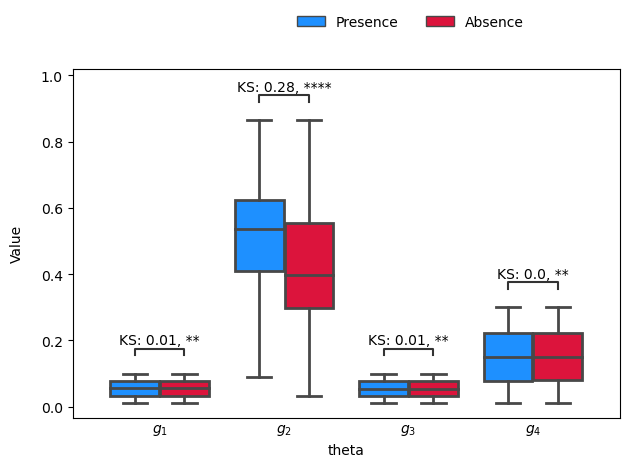

In [ ]:
f2, ax2 = plt.subplots()

labels = [r'$g_1$', r'$g_2$', r'$g_3$', r'$g_4$']
sig_pairs = [(('g_1','Presence'), ('g_1','Absence')),
             (('g_2','Presence'), ('g_2','Absence')),
             (('g_3','Presence'), ('g_3','Absence')),
             (('g_4','Presence'), ('g_4','Absence'))]


boxs = sns.boxplot(x="theta", y="value", data=df, palette=palette, showfliers=False,
               hue='condition', saturation = saturation, dodge=True, ax=ax2, linewidth = 2) 


ks_tests = erp_con_stats.isel(method=0).to_numpy()
custom_annotations = ['KS: ' + str(ks_tests[0, p_ind].round(2)) + ', ' + pval_to_string([ks_tests[1, p_ind]])[0] for p_ind in range(4)]

annotator = Annotator(x = 'theta', y = 'value', hue='condition', pairs = sig_pairs, data=df, ax=boxs)
annotator.set_custom_annotations(custom_annotations)
annotator.annotate()

ax2.set_xticklabels(labels)
ax2.tick_params(axis='both', which='major')
ax2.tick_params(axis = 'x', length = 0)
ax2.legend(ncol = 2, loc = (0.4, 1.1), frameon= False)
ax2.set_ylabel('Value', labelpad = 12)
f2.tight_layout()

In [1051]:
def subpopulationCurrent(t, h, tau):
    return (h/tau) * t * np.exp(-t/tau)

def compute_syn_current(cond_thetas_max):
    
    ex_g_norm = np.sum(cond_thetas_max[0:3, :], axis=0)
    ex_g_norm /= ex_g_norm.max()
    in_g_norm = cond_thetas_max[3,:]
    synRatio = ex_g_norm/in_g_norm
    
    num_cond = 2
    time_vec = np.arange(0, 100, 0.1)
    
    delta, tau_i, h_i, tau_e, h_e, u = DCM_default_params()
    
    I_i = np.zeros((len(time_vec), num_cond))
    I_e = np.zeros((len(time_vec), num_cond))
    auc_i = np.zeros((num_cond))
    auc_e = np.zeros((num_cond))
    
    for c_ind in range(num_cond):
    
        I_i[:, c_ind] = subpopulationCurrent(time_vec, h_i, tau_i)*in_g_norm[c_ind]
        I_e[:, c_ind] = subpopulationCurrent(time_vec, h_e, tau_e)*ex_g_norm[c_ind]
    
        auc_i[c_ind] = np.trapz(y=I_i[:, c_ind], x=time_vec)
        auc_e[c_ind] = np.trapz(y=I_e[:, c_ind], x=time_vec)
    
    EIRatio = auc_e/auc_i
    condEIRatio = EIRatio[0]/EIRatio[1]

    return I_e, I_i, EIRatio, time_vec

In [ ]:
def plot_syn_currents(fig, axes, cond_theta_maxs, x_loc=0.0, y_loc=-0.8, x_offset=0, cond_labels=['Presence', 'Absence'], cond_colors=['royalblue', 'firebrick'], auc_alpha=0.9,
                     lgd_bbox=(1., 0.9), text_x=58, text_y=0.03, suptitle_fontsize=None, labelpad=0, linewidth=0.7, titleweight='normal'):

    num_cond = 2

    I_e, I_i, EIRatio, time_vec = compute_syn_current(cond_theta_maxs)
    I_e /= I_e.max()
    I_i /= I_i.max()
    EIRatio /= EIRatio.max()

    if suptitle_fontsize == None:
        suptitle_fontsize = plt.rcParams['font.size']

    for ax_ind, ax in enumerate(axes):
        
        ax.set_title(cond_labels[ax_ind])
        ax.fill_between(time_vec, I_e[:,ax_ind], color=cond_colors[0], alpha=auc_alpha, edgecolor='k', label='Excitatory', lw=linewidth)
        ax.fill_between(time_vec, -I_i[:,ax_ind], color=cond_colors[1], alpha=auc_alpha, edgecolor='k', label='Inhibitory', lw=linewidth)
    
        ax.text(text_x, text_y, s = 'E/I Ratio: ' + str(round(EIRatio[ax_ind], 3)))
        
        if ax_ind==1:    
            lgd = ax.legend(frameon=False, bbox_to_anchor=lgd_bbox)
        
        ax.tick_params(axis='both', which='major')
        ax.set_title(cond_labels[ax_ind], weight=titleweight, fontsize=suptitle_fontsize)
        modify_axis_spines(ax, which=['x', 'y'], xticks=[0, time_vec[-1].round(-2)], yticks=[-1, 0, 1])
        ax.set_xlabel('Timestep', labelpad=labelpad)
        ax.patch.set_alpha(0.0)

    axes[0].set_ylabel('Normalized PSP', x=x_loc)

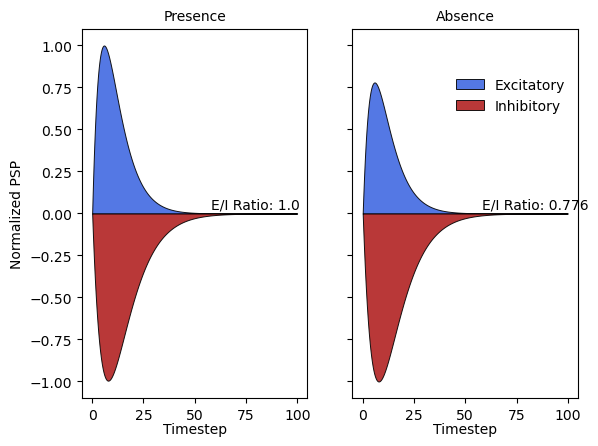

In [1053]:
fig, axes = plt.subplots(1,2, sharey=True)

plot_syn_currents(fig,axes, cond_theta_maxs=posterior_maxs.median('electrode').to_numpy())

In [1209]:
@jax.jit
def DCM_NMM_ERP_ODE_JAXOdeint_full(params, constants, x_init, ts):

    xs_rk4 = odeint_euler(DCM_NMM_ERP_vector_field,  x_init, ts, constants, params)
    
    return xs_rk4

def erp_default_config(tend=100, dt=0.1, t0=0, ns=9, constants=np.array([-0.56])):

    ts = np.arange(t0, tend + dt, dt)
    nt = ts.shape[0]
    x_init=np.zeros((ns))

    return ts, nt, x_init, constants

def simulate_from_posterior(params, tend=100):

    ts, nt, x_init, constants = erp_default_config(tend=tend)
    
    simData = DCM_NMM_ERP_ODE_JAXOdeint_full(params, constants, x_init, ts)

    xsc = simData[:, 0]
    xin = simData[:, 6]
    xpy = simData[:, 8]
    
    return xsc, xin, xpy

In [1216]:
tend = 300.0
ts, nt, x_init, constants = erp_default_config(tend=tend)

In [1217]:
erp_trajectories = xr.DataArray(np.zeros((3, nt, num_electrodes, num_conditions)), dims=('subpopulation', 'time', 'electrode', 'condition'),
                                coords=dict(subpopulation=['SC', 'IN', 'PN'], condition=['Presence', 'Absence']))

In [ ]:
for e_ind in range(erp_trajectories.electrode.shape[0]):
    for c_ind in range(2):
                
        xsc, xin, xpy = simulate_from_posterior(posterior_maxs[:, e_ind, c_ind].to_numpy(), tend=tend)

        erp_trajectories[0, :, e_ind, c_ind] = xsc
        erp_trajectories[1, :, e_ind, c_ind] = xin
        erp_trajectories[2, :, e_ind, c_ind] = xpy
        
        erp_trajectories.to_netcdf(parent_preprocess_dir + 'erp_latent_traj.nc')

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

colors = ['dodgerblue', 'crimson']

for e_ind in range(num_electrodes):
    cond_maxs = erp_trajectories[2, :, e_ind, :].max('time')
    if cond_maxs.diff('condition') < 0:
        for c_ind in range(num_conditions):
            xsc, xin, xpy = erp_trajectories[:, :, e_ind, c_ind]
            ax.plot(xsc, xin, xpy, c=colors[c_ind], lw=3, alpha=0.5) 

In [1228]:
fig, ax = plt.subplots()
e_ind = 13

colors = ['dodgerblue', 'crimson']

for c_ind in range(2):
    ax.plot(task_ERPs[:, e_ind, c_ind], c=colors[c_ind], lw=2)
    ax.plot(erp_trajectories[:, e_ind, c_ind], c=colors[c_ind], lw=5, alpha=0.5) 
ax.set_xlim([180, 450])

(180.0, 450.0)